In [1]:
# Import the necessary libraries that will be needed to carry out the tasks
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
os.chdir('../data/dog-and-cat')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

In [3]:
train_path = 'data/dog-and-cat/train'
valid_path = 'data/dog-and-cat/valid'
test_path = 'data/dog-and-cat/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat','dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [6]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [7]:
import sys
from PIL import Image
sys.modules['Image'] = Image

In [8]:
imgs, labels = next(train_batches)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

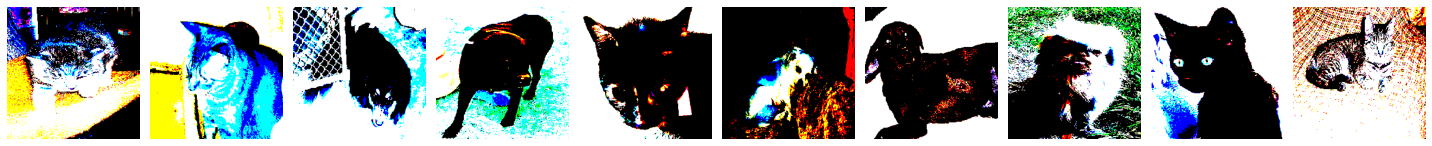

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [10]:
plotImages(imgs)
print(labels)

In [11]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [13]:
model1 = Sequential([
    Dense(3, input_shape=(2,), activation='relu'),
    Dense(2, activation='softmax')
])

In [14]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [15]:
model1.get_weights()

[array([[ 0.29130614,  0.34976828,  1.0609512 ],
        [ 0.6090871 , -0.70109284, -0.43322366]], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([[ 0.2829771 ,  0.9954665 ],
        [-0.8171413 ,  0.8526474 ],
        [ 0.25183535, -0.27865773]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=3, verbose=2)

Epoch 1/3
100/100 - 942s - loss: 1.1123 - accuracy: 0.8380 - val_loss: 3.3224 - val_accuracy: 0.6800
Epoch 2/3
100/100 - 1151s - loss: 0.3380 - accuracy: 0.9370 - val_loss: 2.9199 - val_accuracy: 0.6300
Epoch 3/3
100/100 - 693s - loss: 0.1940 - accuracy: 0.9510 - val_loss: 4.3123 - val_accuracy: 0.5900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

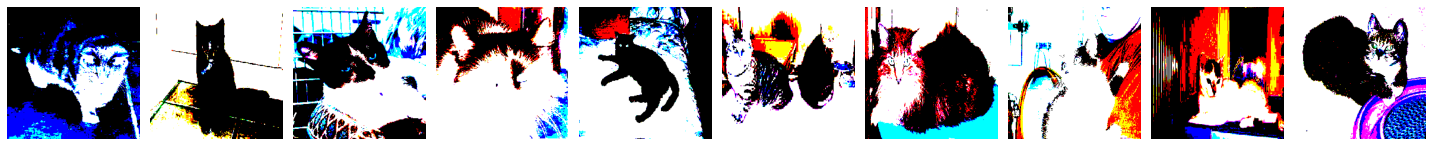

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [19]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [20]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
predictions = model.predict(x=test_batches, verbose=0)

In [22]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.

In [23]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [24]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[16 34]
 [ 6 44]]


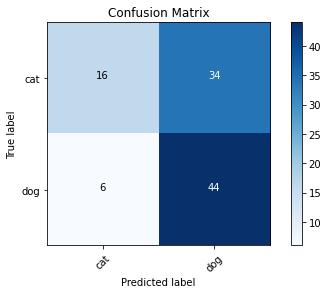

In [26]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 4s 0us/step


In [31]:
def prepare_image(file):
    img_path = 'C:/Users/M/Desktop/vision/vehicle'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

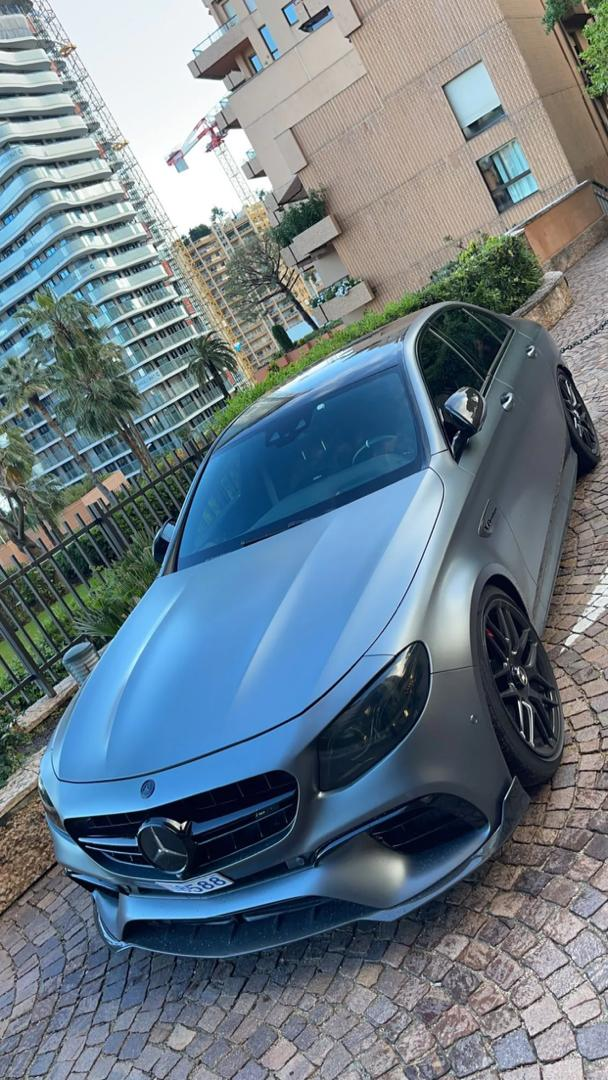

In [32]:
from IPython.display import Image
Image(filename='C:/Users/M/Desktop/vision/vehicle/car.jpeg', width=300, height=200)

In [35]:
preprocessed_image = prepare_image('/car.jpeg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)  #Top five predictions from the 1000 possible ImageNet classes
results

40960/35363 [==================================] - 0s 5us/step


[[('n03791053', 'motor_scooter', 0.7325406),
  ('n03785016', 'moped', 0.13911913),
  ('n04285008', 'sports_car', 0.042934526),
  ('n03100240', 'convertible', 0.040160455),
  ('n03459775', 'grille', 0.013605588)]]